# Guided Backpropagation

Guided backpropagation is a combination of the gradient and deconvolution attribution methods. The deconvolution method discussed in [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034), was shown to be equivalent to a backward pass through the network, except for its interaction with the relu layer. The negative gradient values would be zeroed by relu, but the gradient values coming from negative input image values were not zeroed. Guided backpropagation method adapts this idea by **zeroing both negative gradients and gradients coming from negative input values**. We will implement this method by introducing a new relu layer called guided relu. Unfortunately guided relu performs poorly when training, so the model will first be trained with relu layers, then the relu layers will be swapped out for the guided relu layers when evaluating the attribution maps. There is no obvious way to swap layers in flax, so instead we will define a new model with the same architecture but guided relu inplace of relu layers.  

For more technical information on the guided backpropagation attribution method see: [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import custom_vjp
import flax.linen as nn

import jax
from jax import random
from jax import grad
import optax

import requests
import zipfile
import flaxmodels
from PIL import Image
from flax.core.frozen_dict import freeze
import cv2
from scipy.ndimage import zoom



In [2]:
image_path = 'storage/datasets/imagenet_subset/n01534433_9.JPEG'


In [3]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

### Load training data
Check if the training data exists. If not, automatically download it.

In [4]:
def preprocess_image(img: jnp.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) -> jnp.ndarray:
    """
    Preprocesses the image by normalizing it with the given mean and standard deviation.
    
    Args:
        img (jnp.ndarray): The image as a JAX array.
        mean (list): The mean for normalization.
        std (list): The standard deviation for normalization.
    
    Returns:
        jnp.ndarray: The preprocessed image.
    """
    mean = jnp.array(mean).reshape(1, 1, 3)
    std = jnp.array(std).reshape(1, 1, 3)
    img = (img - mean) / std
    img = jnp.clip(img, 0.0, 1.0)
    return img

rgb_img = cv2.imread(image_path, 1)[:, :, ::-1] # `::-1`: Selects all channels but in reverse order, resulting in the RGB image.
rgb_img = np.float32(rgb_img) / 255
    
preprocessed_img = preprocess_image(rgb_img)
input_tensor = jnp.expand_dims(preprocessed_img, axis=0) # Whether to use preprocessing


2024-07-26 06:44:04.624399: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


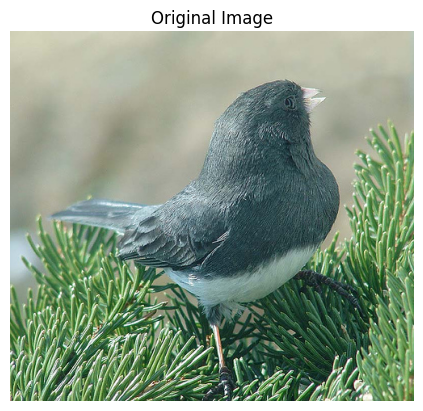

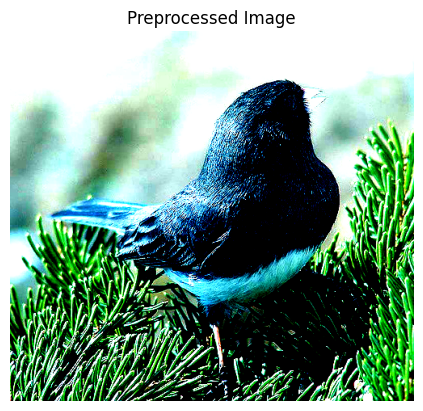

In [5]:
def plot_image(img: jnp.ndarray, title: str = 'Image'):
    """
    Plots a JAX image array.
    
    Args:
        img (jnp.ndarray): The image array to plot.
        title (str): Title of the plot.
    """
    img = np.array(img)  # Convert JAX array to NumPy array for plotting
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
H, W, C = rgb_img.shape


plot_image(rgb_img, title='Original Image')
plot_image(preprocessed_img, title='Preprocessed Image')


# Create model with grad-cam hook

In [6]:
model = flaxmodels.ResNet152Customized(output='logits', pretrained='imagenet', observe_layers=[4,])
# model = flaxmodels.ResNet50(output='logits', pretrained='imagenet')

rng_key = random.PRNGKey(0)

variables = model.init(rng_key, input_tensor) # {'params': ..., 'batch_stats': ..., 'perturbations': ...}

logits = model.apply(variables, input_tensor, train=False)
prediction = get_predictions(logits)
print(prediction) # probabilities for 1000 classes

# print(model.tabulate(rng_key, input_tensor))
# print(variables)


[13]


### Display predictions and attribution maps

The final convolutional layer values and gradients are required to perform Grad-CAM. To access the convolutional layer it needs to be stored as an intermediate variable in the model definition, then the "mutable='intermediates'" argument is supplied to the model when performing the forward pass. The gradients of the final convolutional layer is extracted by passing the final convolutional layers values as a perturbation parameter to the loss function, then calculating the gradients of the perturbation parameter. Global average pooling is then applied to the convolutional layers gradients to extract the weightings. This is performed by taking the mean of each filter/feature map, this results in a vector of floats with the size of the number of feature maps. The vector is then used as weights for the feature maps. The dot product is taken between the weights and feature maps to provide us with the class activation mapping. 

### Create new loss function with guided model

A new loss function containing the model with guided relu layers is required when performing gradient calculations for the attribution attribution maps.

In [7]:
def loss_fn(model, params, batch_stats, perturbations, X, Y):
    '''
    Classification loss function.
    In Grad-CAM, we want to get the grad of the last layer w.r.t. the target label, instead of the loss.
    To do this, we still define the loss function, but we use the negated gradients, since d(-L) / dx == - d(L) / dx
    '''
    variables = {
        'params': params,
        'batch_stats': batch_stats,
        'perturbations': perturbations
    }
    
    logits = model.apply(variables, X, train=False)
    predictions = get_predictions(logits)
    
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, Y)
    loss = loss.mean()
    return loss

### Display predictions and attribution maps

The gradients are calculated with the new guided loss function. The gradients are then normalized in the standard way for visualization.

In [8]:
def make_predictions(model, variables, X):
    logits, state = model.apply(variables, X, train=False, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state


def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)

def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            if len(img.shape) > 3:
                img = zoom(np.float32(img), [
                           (t_s / i_s) for i_s, t_s in zip(img.shape, target_size[::-1])])
            else:
                img = cv2.resize(np.float32(img), target_size)

        result.append(img)
    result = np.float32(result)

    return result
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img # RGB headmap + RGB image
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def display_prediction(model, variables, img, input_tensor, target=None):
    prediction, state = make_predictions(model, variables, input_tensor)
    # Extract final conv layers values
    final_conv_layer_activations = state["intermediates"]["gradcam_sow_4"][0]
    
    if target is None:
        target = prediction
    print("Prediction: ", prediction)
    print("Target: ", target)
    
    # For input image
    B, H, W, C = input_tensor.shape
    assert B==1
    plot_image(input_tensor[0], title='Preprocessed Image')
    
    # For grad-cam hooked model
    perturbations = freeze({"gradcam_perturb_4": final_conv_layer_activations}) # This is the perturbation that we will use to extract the gradients.
    final_conv_grads = grad(loss_fn, argnums=3)(model, variables['params'], variables['batch_stats'], perturbations, input_tensor, target) # Use negated grad
    final_conv_grads = -final_conv_grads["gradcam_perturb_4"] # Here I use the negated gradients w.r.t. the classificaiton loss to get the positive contributions.
    
    
    # Get weights using global average pooling
    weights = jnp.mean(final_conv_grads, axis=(1, 2))# (B, H', W', C') -> (B, H'*W'*C') 
    # Get the weighted sum of all the filters
    
    weighted_activations = weights[:, None, None, :] * final_conv_layer_activations 
    
    target_size = (W, H)
    cam = jnp.sum(weighted_activations, axis=-1) # (B, H', W', C')
    cam = jnp.maximum(cam, 0) # They take only the positive contributions by applying a RELU function:
    scaled = scale_cam_image(cam, target_size) # (B, H, W)
    
    grayscale_cam = scaled[0, :]
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    plot_image(cam_image, title='Grad-CAM')
    
    # # plt.gray()
    # plt.imshow(attributions, interpolation='nearest')
    # plt.axis('off')
    # plt.title("Attribution Map")
    # plt.show()

Prediction:  [13]
Target:  [13]


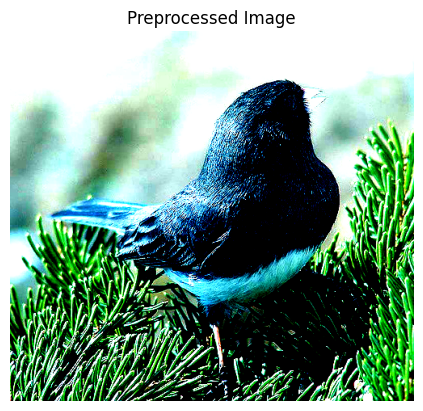

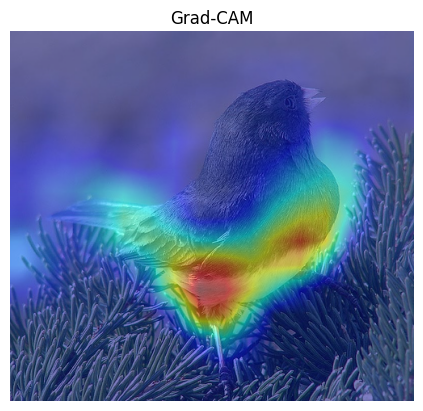

In [9]:
display_prediction(model, variables, rgb_img, input_tensor)
# display_prediction(replaced_model, variables, input_tensor)

# display_prediction(3, params)
# display_prediction(5, params)
# display_prediction(8, params)
# display_prediction(10, params)
# display_prediction(50, params)